# Project: Object Detection using Machine Learning by making use of Sliding Window Technique

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
from skimage.feature import hog
from skimage import color
from google.colab.patches import cv2_imshow
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from skimage.filters import prewitt_h,prewitt_v

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Initializing and Loading Data

In [5]:
dataset = '/content/drive/MyDrive/dataset'

### Read images

In [6]:
def read_images(folder):
    images = []
    for filename in os.listdir(folder):
      img = cv2.imread(os.path.join(folder, filename),0)
      img = cv2.resize(img,(64,64),interpolation=cv2.INTER_CUBIC)
      images.append(img)
      #img = np.flipud(img)
      #images.append(img)
    return images

In [7]:
# Reading images
folders = [os.path.join(dataset, x) for x in ('cars', 'motorcycles', 'non-vehicles')]
images= []
labels = []
for folder in folders:
  imgs = read_images(folder)
  for i in range(len(imgs)):
    images.append(imgs[i])
    labels.append(folder.split('/')[-1])


### Visualising some of the images

(64, 64)

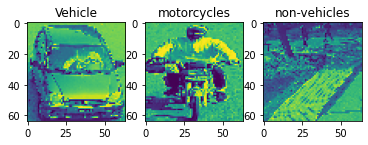

In [9]:
##Visualise some images  
#figure, (vehicle, motorcycle ,non_vehicle) = plt.subplots(1, 3, figsize=(10,5))
plt.subplot(1, 3, 1)        
plt.title('Vehicle')
plt.imshow(images[10])
plt.subplot(1, 3, 2)
plt.title('motorcycles')
plt.imshow(images[5000])
plt.subplot(1, 3, 3)
plt.title('non-vehicles')
plt.imshow(images[8001])
images[8001].shape
#non_vehicle_plot.set_title('Non-vehicle image')
#non_vehicle_plot.imshow(cv2.cvtColor(non_vehicle_img, cv2.COLOR_BGR2RGB))

## Feature Extraction: Extracting features from the image data using HOG, Colour Hist and Spatial Binning

In [10]:
def color_hist(file):
    ch1_hist = np.histogram(file[:,:,0], bins=32, range=(0, 1))
    ch2_hist = np.histogram(file[:,:,1], bins=32, range=(0, 1))
    ch3_hist = np.histogram(file[:,:,2], bins=32, range=(0, 1))
    # return single vector 
    return np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))

In [11]:
def spatial_binning(file):
    return cv2.resize(file, (32,32),interpolation=cv2.INTER_CUBIC).ravel() 

In [12]:
def hog_features(img,orient=9, ppc=8, cpb=2, vis=False, feature_vec=True):

  if vis == True:
    features, image = hog(img, orientations=orient, pixels_per_cell=(ppc, ppc),
                            cells_per_block=(cpb, cpb), transform_sqrt=True, 
                            visualize=vis, feature_vector=feature_vec)
    return features, image
  else:      
    features = hog(img, orientations=orient, pixels_per_cell=(ppc, ppc),
                  cells_per_block=(cpb, cpb), transform_sqrt=True, 
                  visualize=vis, feature_vector=feature_vec)
    return features
def edge_(img): ## Edge detection
  edges_prewitt_vertical = prewitt_v(img)
  return edges_prewitt_vertical.flatten()


In [13]:
## Extract feature function
def extract_features(imgs):
    # Create a list to append feature vectors to
    features2 = []
    # Iterate through the list of images
    for file in imgs:
        features = []
        features.append(spatial_binning(file)) ###Spatial binning
        #features.append(color_hist(file)) ### color hist
        # Append the new feature vector to the features list
        features.append(hog_features(file)) ##### HOG
        #features.append(edge_(file))  # Edge detection    
    # Return list of feature vectors
        features2.append(np.concatenate(features))
    return features2


### Visualising HOG features

(1764,)

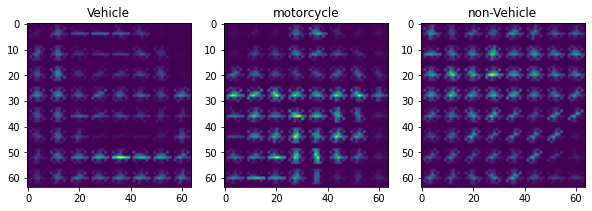

In [14]:
##### Visualise some hog features
plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)        
plt.title('Vehicle')
plt.imshow(hog_features(images[10],vis=True)[1] )

plt.subplot(1, 3, 2)        
plt.title('motorcycle')
plt.imshow(hog_features(images[5000],vis=True)[1] )

plt.subplot(1, 3, 3)        
plt.title('non-Vehicle')
plt.imshow(hog_features(images[8001],vis=True)[1] )
hog_features(images[8001],vis=True)[0].shape

## Train different models using extractated features. 

### Following is the modelling of SVM classifier

In [15]:

########### Model classifier (SVM)
X = extract_features(images)
#Normalise 
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
####################################


# extract lenghts of each category 
cars = [x for x in labels if x=='cars']
motorcycles = [x for x in labels if x=='motorcycles']
non_vehicles = [x for x in labels if x=='non-vehicles']

# labels vector 1 for cars, 2 for motorcycles and 3 for non-vehicles
y = np.hstack((np.ones(len(cars)),np.full(len(motorcycles), 2), np.zeros(len(non_vehicles))))

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.4, random_state=42)

#################

## Usung SVM
svc = LinearSVC()

# Train the model
svc.fit(X_train, y_train)

# Evaluate
Accuracy_SVC = svc.score(X_test, y_test)
print('Accuracy SVC: ',Accuracy_SVC)



Accuracy SVC:  0.9901538461538462


### Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)
lr_pred = clf_nb.predict(X_test)
NB_accuracy = accuracy_score(y_test, lr_pred)
print("Accuracy Naive Bayes:",NB_accuracy)

Accuracy Naive Bayes: 0.9553846153846154


### Artificial Neural Network Classification

In [ ]:
#Artificial Neural Network Classification

ann = models.Sequential([
        layers.Flatten(input_shape=(2788,)),
        layers.Dense(300, activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dense(3, activation='softmax')    
    ])

ann.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ann.fit(X_train, y_train, epochs=10)

y_pred = ann.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
#print("Classification Report: \n", classification_report(y_test, np.array(y_pred_classes)))
Accuracy_ann = accuracy_score(y_test, y_pred_classes)
print("Accuracy Score: ", Accuracy_ann)

Epoch 1/10
153/153 [==============================] - 2s 10ms/step - loss: 0.1691 - accuracy: 0.9454
Epoch 2/10
153/153 [==============================] - 1s 10ms/step - loss: 0.0344 - accuracy: 0.9941
Epoch 3/10
153/153 [==============================] - 1s 8ms/step - loss: 0.0180 - accuracy: 0.9971
Epoch 4/10
153/153 [==============================] - 1s 6ms/step - loss: 0.0112 - accuracy: 0.9986
Epoch 5/10
153/153 [==============================] - 1s 6ms/step - loss: 0.0078 - accuracy: 0.9994
Epoch 6/10
153/153 [==============================] - 1s 6ms/step - loss: 0.0058 - accuracy: 0.9996
Epoch 7/10
153/153 [==============================] - 1s 6ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 8/10
153/153 [==============================] - 1s 7ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 9/10
153/153 [==============================] - 1s 9ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 10/10
153/153 [==============================] - 1s 8ms/step - loss: 0.0027 - accuracy: 1.00

### Classifier: Logistic Regression

In [ ]:
## Try another classifier. Logistic Regression
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
lr_pred = clf.predict(X_test)


logistic_regression_accuracy = accuracy_score(y_test, lr_pred)
print("Accuracy Logitic regression:",logistic_regression_accuracy)


Accuracy Logitic regression: 0.9913846153846154


In [ ]:
from tabulate import tabulate
 
# assign data
_data = [
    ["SVM", Accuracy_SVC*100],
    ["Logitic regression", logistic_regression_accuracy*100],
    [" Neural Network", Accuracy_ann*100],
      ["Naive Bayes", NB_accuracy*100]
]
 
# create header
head = ["Classifier", "Accuracy (%)"]
 
# display table
print(tabulate(_data, headers=head, tablefmt="grid"))

+--------------------+----------------+
| Classifier         |   Accuracy (%) |
+====================+================+
| SVM                |        98.9538 |
+--------------------+----------------+
| Logitic regression |        99.1385 |
+--------------------+----------------+
| Neural Network     |        98.8308 |
+--------------------+----------------+
| Naive Bayes        |        95.5385 |
+--------------------+----------------+


## Testing on Video Data

In [16]:
def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

### Test sliding window technique on a single video frame

In [17]:
vcap = cv2.VideoCapture(dataset+'/sample videos/sample.mp4')
s,imag = vcap.read()
temp=imag
j=0
while(j<5):
  image = imag[:,:,0]
  s,imag = vcap.read()
  temp=imag
  j+=1

image = cv2.resize(image,(500,500),interpolation=cv2.INTER_CUBIC)
temp = cv2.resize(temp,(500,500),interpolation=cv2.INTER_CUBIC)
X_scaler = StandardScaler().fit(X)
#plt.imshow(image)

yes


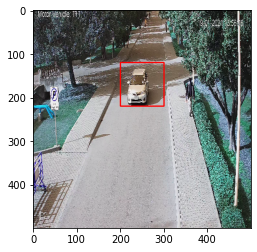

In [20]:
tmp = image
ii=1
step=80
for (x,y,window) in sliding_window(image, 40, (100,100)):
  if window.shape[0] != 100 or window.shape[1] != 100: continue
  window = cv2.resize(window,(64,64),interpolation=cv2.INTER_CUBIC)
  featureVector = extract_features([window])
  feat = X_scaler.transform(featureVector)
  pred = svc.predict(feat)
  if pred==1 and ii==1:
    print('yes')
    ii+=1
    tmp = cv2.rectangle(temp, (x, y), (x+100, y+100), (255, 0, 0), 2) 
    plt.imshow(np.array(temp))

### Run sliding window technique on each frame of the video. Save all frames

In [23]:
vcap = cv2.VideoCapture(dataset+'/sample videos/sample.mp4')
s, image = vcap.read()
temp=image
j=0
vid_data = []
step = 40
while(s):
 
  if j<20: step=40
  elif j<45: step=55
  elif j<55: step=65
  elif j<70: step=70
  elif j<80: step=90
  else: step=100

  image = image[:,:,0]
  X_scaler = StandardScaler().fit(X)

  image = cv2.resize(image,(500,500),interpolation=cv2.INTER_CUBIC)
  temp = cv2.resize(temp,(500,500),interpolation=cv2.INTER_CUBIC)
  tmp = image
  ii=1
  #step=120
  for (x,y,window) in sliding_window(image, step, (100,100)):
    if window.shape[0] != 100 or window.shape[1] != 100: continue
    window = cv2.resize(window,(64,64),interpolation=cv2.INTER_CUBIC)
    featureVector = extract_features([window])
    feat = X_scaler.transform(featureVector)
    pred = svc.predict(feat)

    if pred==1 and ii==1:
      #print('yes')
      ii+=1
      temp = cv2.rectangle(temp, (x, y), (x+100, y+100), (255, 0, 0), 2) 
      vid_data.append(np.array(temp))
  j+=1

  s,image = vcap.read()
  temp=image


### Saving Video

In [24]:
import imageio
writer = imageio.get_writer('output.mp4', fps=8)

for im in range(0,len(vid_data)):
    writer.append_data(vid_data[im])
writer.close()

# Using Neural Networks (+CNN) for Object Detection!

## Importing Libraries and Mounting Drive

In [ ]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from skimage.io import imread_collection
from skimage import data, color
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score

import cv2
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

In [ ]:
# Mount Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Training using Existing Data

### Loading Data from Drive

In [ ]:

X_total = np.load('/content/drive/MyDrive/MLProject/img_data_64.npy')
y_total = np.load('/content/drive/MyDrive/MLProject/labels_data.npy')

X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.2)

print(X_total.shape, X_train.shape, X_test.shape)

(8100, 64, 64) (6480, 64, 64) (1620, 64, 64)


### Augmenting the Training Data after Flipping up-down and left-right

In [ ]:
def augment_image_data(X):

  X2 = X[:,:,::-1] # flip lr
  X3 = X[:,::-1,:] # flip ud
  return np.concatenate((X,X2,X3))

def augment_label_data(Y):
  return np.concatenate((Y,Y,Y))

In [ ]:
X_total_aug = augment_image_data(X_total)
y_total_aug = augment_label_data(y_total)

X_train, X_test, y_train, y_test = train_test_split(X_total_aug, y_total_aug, test_size=0.2)

print(X_total.shape, X_total_aug.shape, y_total_aug.shape, X_train.shape, X_test.shape)

(8100, 64, 64) (24300, 64, 64) (24300,) (19440, 64, 64) (4860, 64, 64)


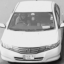

In [ ]:
cv2_imshow(X_test[8]*255)

(4860, 64, 64)

### Training Hog-Features based Artificial Neural Network

In [ ]:
def hog_features(img,orient=9, ppc=8, cpb=2, vis=False, feature_vec=True):

  if vis == True:
    features, image = hog(img, orientations=orient, pixels_per_cell=(ppc, ppc),
                            cells_per_block=(cpb, cpb), transform_sqrt=True, 
                            visualize=vis, feature_vector=feature_vec)
    return features, image
  else:      
    features = hog(img, orientations=orient, pixels_per_cell=(ppc, ppc),
                  cells_per_block=(cpb, cpb), transform_sqrt=True, 
                  visualize=vis, feature_vector=feature_vec)
    return features

In [ ]:
hog_test = []
hog_train = []

for img in X_test:
  hog_test.append(hog_features(img))

for img in X_train:
  hog_train.append(hog_features(img))

hog_test = np.array(hog_test)
hog_train = np.array(hog_train)

In [ ]:
hog_train.shape

(19440, 1764)

In [ ]:
ann_hog = models.Sequential([
        layers.Flatten(input_shape=(1764,)),
        layers.Dense(300, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(3, activation='softmax')    
    ])

ann_hog.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ann_hog.fit(hog_train, y_train, epochs=80)

Epoch 1/80
608/608 [==============================] - 4s 5ms/step - loss: 0.3393 - accuracy: 0.9103
Epoch 2/80
608/608 [==============================] - 3s 5ms/step - loss: 0.0956 - accuracy: 0.9754
Epoch 3/80
608/608 [==============================] - 3s 5ms/step - loss: 0.0648 - accuracy: 0.9833
Epoch 4/80
608/608 [==============================] - 3s 5ms/step - loss: 0.0520 - accuracy: 0.9865
Epoch 5/80
608/608 [==============================] - 3s 5ms/step - loss: 0.0445 - accuracy: 0.9884
Epoch 6/80
608/608 [==============================] - 3s 5ms/step - loss: 0.0396 - accuracy: 0.9898
Epoch 7/80
608/608 [==============================] - 4s 6ms/step - loss: 0.0359 - accuracy: 0.9900
Epoch 8/80
608/608 [==============================] - 4s 6ms/step - loss: 0.0329 - accuracy: 0.9912
Epoch 9/80
608/608 [==============================] - 3s 5ms/step - loss: 0.0302 - accuracy: 0.9917
Epoch 10/80
608/608 [==============================] - 3s 5ms/step - loss: 0.0280 - accuracy: 0.9928

In [ ]:
y_pred = ann_hog.predict(hog_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
print("Classification Report: \n", classification_report(y_test, np.array(y_pred_classes)))
print("Accuracy Score: ", accuracy_score(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1561
           1       1.00      0.98      0.99      2084
           2       0.98      0.98      0.98      1215

    accuracy                           0.99      4860
   macro avg       0.99      0.99      0.99      4860
weighted avg       0.99      0.99      0.99      4860

Accuracy Score:  0.9874485596707819


### Training Artificial Neural network with all the pixels as input!

In [ ]:
ann = models.Sequential([
        layers.Flatten(input_shape=(64,64)),
        layers.Dense(100, activation='relu'),
        layers.Dense(24, activation='relu'),
        layers.Dense(3, activation='softmax')    
    ])

ann.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ann.fit(X_train, y_train, epochs=70)

Epoch 1/70
608/608 [==============================] - 3s 4ms/step - loss: 0.5087 - accuracy: 0.8001
Epoch 2/70
608/608 [==============================] - 3s 4ms/step - loss: 0.3045 - accuracy: 0.8994
Epoch 3/70
608/608 [==============================] - 3s 4ms/step - loss: 0.2469 - accuracy: 0.9181
Epoch 4/70
608/608 [==============================] - 3s 4ms/step - loss: 0.2165 - accuracy: 0.9283
Epoch 5/70
608/608 [==============================] - 3s 4ms/step - loss: 0.1912 - accuracy: 0.9391
Epoch 6/70
608/608 [==============================] - 3s 4ms/step - loss: 0.1727 - accuracy: 0.9442
Epoch 7/70
608/608 [==============================] - 3s 4ms/step - loss: 0.1515 - accuracy: 0.9508
Epoch 8/70
608/608 [==============================] - 3s 4ms/step - loss: 0.1422 - accuracy: 0.9540
Epoch 9/70
608/608 [==============================] - 3s 4ms/step - loss: 0.1329 - accuracy: 0.9562
Epoch 10/70
608/608 [==============================] - 3s 4ms/step - loss: 0.1183 - accuracy: 0.9630

In [ ]:
y_pred = ann.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
print("Classification Report: \n", classification_report(y_test, np.array(y_pred_classes)))
print("Accuracy Score: ", accuracy_score(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1561
           1       0.97      0.98      0.98      2084
           2       0.98      0.95      0.97      1215

    accuracy                           0.98      4860
   macro avg       0.98      0.97      0.98      4860
weighted avg       0.98      0.98      0.98      4860

Accuracy Score:  0.9767489711934156


### Training Convolutional Neural Network

In [ ]:
cnn = models.Sequential([
    layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu', input_shape=(64, 64,1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(3, activation='softmax')
])

cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn.fit(X_train, y_train, epochs=10)

Epoch 1/10
608/608 [==============================] - 42s 68ms/step - loss: 0.2701 - accuracy: 0.8885
Epoch 2/10
608/608 [==============================] - 41s 68ms/step - loss: 0.0898 - accuracy: 0.9728
Epoch 3/10
608/608 [==============================] - 41s 68ms/step - loss: 0.0668 - accuracy: 0.9801
Epoch 4/10
608/608 [==============================] - 41s 68ms/step - loss: 0.0508 - accuracy: 0.9857
Epoch 5/10
608/608 [==============================] - 41s 68ms/step - loss: 0.0381 - accuracy: 0.9883
Epoch 6/10
608/608 [==============================] - 41s 68ms/step - loss: 0.0294 - accuracy: 0.9913
Epoch 7/10
608/608 [==============================] - 41s 68ms/step - loss: 0.0321 - accuracy: 0.9903
Epoch 8/10
608/608 [==============================] - 41s 68ms/step - loss: 0.0202 - accuracy: 0.9942
Epoch 9/10
608/608 [==============================] - 42s 68ms/step - loss: 0.0166 - accuracy: 0.9950
Epoch 10/10
608/608 [==============================] - 42s 68ms/step - loss: 0.017

In [ ]:
y_pred = cnn.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
print("Classification Report: \n", classification_report(y_test, np.array(y_pred_classes)))
print("Accuracy Score: ", accuracy_score(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1561
           1       0.99      0.98      0.99      2084
           2       0.98      0.98      0.98      1215

    accuracy                           0.98      4860
   macro avg       0.98      0.98      0.98      4860
weighted avg       0.98      0.98      0.98      4860

Accuracy Score:  0.9847736625514403


## Testing on the Video Data

### Loading VIdeos

In [ ]:
import pylab
import imageio
filename = '/content/drive/MyDrive/MLProject/dataset_v4/sample videos/sample.mp4'
vid = imageio.get_reader(filename,  'ffmpeg')
nums = [10, 287]

vid_data = []
for i, im in enumerate(vid):
    #print('Mean of frame %i is %1.1f' % (i, im.mean()))
    vid_data.append(im)


filename = '/content/drive/MyDrive/MLProject/dataset_v4/sample videos/sample_2.mp4'
vid = imageio.get_reader(filename,  'ffmpeg')

vid_data2 = []
for i, im in enumerate(vid):
    #print('Mean of frame %i is %1.1f' % (i, im.mean()))
    vid_data2.append(im)

print(f'Video 1: Number of frame: {len(vid_data)} and Shape of each frame {vid_data[2].shape}')
print(f'Video 2: Number of frame: {len(vid_data2)} and Shape of each frame {vid_data2[2].shape}')

Video 1: Number of frame: 100 and Shape of each frame (1520, 2688, 3)
Video 2: Number of frame: 126 and Shape of each frame (1520, 2688, 3)


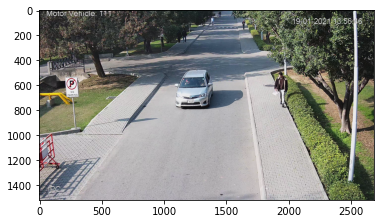

In [ ]:
plt.imshow(vid_data[20])

### Practice Sliding Window Classifications

In [ ]:
def sliding_window_func(image, stepSize, windowSize):
  # slide a window across the image
  sizes = []
  for y in range(0, image.shape[0]-int(windowSize[0]/2), stepSize):
    for x in range(0, image.shape[1]-int(windowSize[1]/2), stepSize):
      # yield the current window
      yield(x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

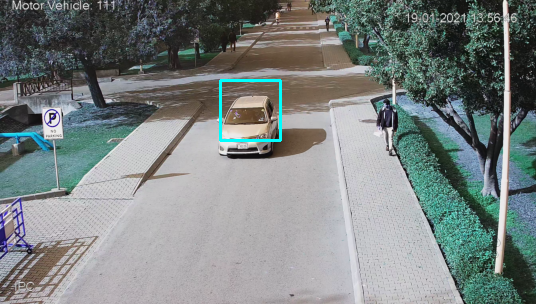

In [ ]:
working_test = resize(rgb2gray(vid_data[5]), (152*2, 268*2), anti_aliasing=True)
tmp0 = resize(vid_data[20], (152*2, 268*2), anti_aliasing=True)
tmp = working_test.copy()
tmp2 = working_test.copy()
count = 0
wins = []
ones = []
ones_ann = []
winsizex = 60
winsizey = 60
test_wins = []
hog_wins = []
for (winx, winy, winimg) in sliding_window_func(image=working_test,stepSize=20,windowSize=(winsizex,winsizey)):
  wins.append([winx,winy])
  test_wins.append(resize(winimg, (64, 64), anti_aliasing=True))
  hog_wins.append(hog_features(resize(winimg, (64, 64), anti_aliasing=True)))
  #test_wins.append(winimg)

y_pred_cnn = cnn.predict(np.array(test_wins))
y_pred_ann = ann.predict(np.array(test_wins))
y_pred_hogann = ann_hog.predict(np.array(hog_wins))

y_class_cnn = [np.argmax(element) for element in y_pred_cnn]
y_class_ann = [np.argmax(element) for element in y_pred_ann]
y_class_hogann = [np.argmax(element) for element in y_pred_hogann]
#y_class_moto_cnn = 
result_cnn = np.where(y_class_cnn == np.int64(1))
result_ann = np.where(y_class_ann == np.int64(1))
result_hogann = np.where(y_class_hogann == np.int64(1))

result_cnn2 = np.where(y_pred_cnn.max(axis=1)[result_cnn] > 0.99)
result_ann2 = np.where(y_pred_ann.max(axis=1)[result_ann] > 0.945)

hogann_max = np.argsort(y_pred_hogann[:,1], axis=0)[-1]

#if result_hogann.shape[]
#intersect = np.intersect1d(result_ann,result_hogann,result_cnn)
intersect = [hogann_max.copy()]
for idx in intersect:
  winx, winy = wins[idx]
  cv2.rectangle(tmp0, (winx, winy), (winx+winsizex, winy+winsizey), (150, 40, 0), 2)

cv2_imshow(tmp0*255)

### Final Classification of Video 1

In [ ]:
output_viddata = []
cc = 0
for vid in vid_data:
  if cc < 30:
    winsizex = 50
    winsizey = 70
    stepS = 25
  elif cc < 80:
    winsizex = 120
    winsizey = 130
    stepS = 50
  else:
    winsizex= 130
    winsizey = 150
    stepS = 50

  cc += 1
  working_test = resize(rgb2gray(vid), (152*2, 268*2), anti_aliasing=True)
  tmp0 = resize(vid, (152*2, 268*2), anti_aliasing=True)
  tmp = working_test.copy()
  tmp2 = working_test.copy()
  count = 0
  wins = []
  ones = []
  ones_ann = []
  test_wins = []
  hog_wins = []
  for (winx, winy, winimg) in sliding_window_func(image=working_test,stepSize=stepS,windowSize=(winsizex,winsizey)):
    wins.append([winx,winy])
    test_wins.append(resize(winimg, (64, 64), anti_aliasing=True))
    hog_wins.append(hog_features(resize(winimg, (64, 64), anti_aliasing=True)))
    #test_wins.append(winimg)

  y_pred_cnn = cnn.predict(np.array(test_wins))
  y_pred_ann = ann.predict(np.array(test_wins))
  y_pred_hogann = ann_hog.predict(np.array(hog_wins))

  y_class_cnn = [np.argmax(element) for element in y_pred_cnn]
  y_class_ann = [np.argmax(element) for element in y_pred_ann]
  y_class_hogann = [np.argmax(element) for element in y_pred_hogann]
  #y_class_moto_cnn = 
  result_cnn = np.where(y_class_cnn == np.int64(1))
  result_ann = np.where(y_class_ann == np.int64(1))
  result_hogann = np.where(y_class_hogann == np.int64(1))

  result_cnn2 = np.where(y_pred_cnn.max(axis=1)[result_cnn] > 0.96)
  result_ann2 = np.where(y_pred_ann.max(axis=1)[result_ann] > 0.93)

  intersect = np.intersect1d(result_cnn, result_hogann) #, result_ann)

  # if intersect:
  #   max_idx = np.argmax(y_pred_cnn.max(axis=1)[intersect])

  #   winx, winy = wins[intersect[max_idx]]
  #   cv2.rectangle(tmp, (winx, winy), (winx+winsizex, winy+winsizey), (150, 40, 0), 2)
  tmp = tmp*255
  tmp0 = tmp0*255
  for idx in intersect:
    winx, winy = wins[idx]
    
    cv2.rectangle(tmp0, (winx, winy), (winx+winsizex, winy+winsizey), (150, 40, 0), 2)

  output_viddata.append(resize(tmp0, (152*2, 268*2), anti_aliasing=True))
  print('Frame ',cc, 'Num of Rects: ',intersect.shape)

Frame  1 Num of Rects:  (1,)
Frame  2 Num of Rects:  (1,)
Frame  3 Num of Rects:  (0,)
Frame  4 Num of Rects:  (0,)
Frame  5 Num of Rects:  (0,)
Frame  6 Num of Rects:  (0,)
Frame  7 Num of Rects:  (1,)
Frame  8 Num of Rects:  (1,)
Frame  9 Num of Rects:  (2,)
Frame  10 Num of Rects:  (2,)
Frame  11 Num of Rects:  (2,)
Frame  12 Num of Rects:  (1,)
Frame  13 Num of Rects:  (2,)
Frame  14 Num of Rects:  (2,)
Frame  15 Num of Rects:  (2,)
Frame  16 Num of Rects:  (1,)
Frame  17 Num of Rects:  (2,)
Frame  18 Num of Rects:  (2,)
Frame  19 Num of Rects:  (3,)
Frame  20 Num of Rects:  (2,)
Frame  21 Num of Rects:  (4,)
Frame  22 Num of Rects:  (3,)
Frame  23 Num of Rects:  (4,)
Frame  24 Num of Rects:  (3,)
Frame  25 Num of Rects:  (3,)
Frame  26 Num of Rects:  (3,)
Frame  27 Num of Rects:  (2,)
Frame  28 Num of Rects:  (2,)
Frame  29 Num of Rects:  (2,)
Frame  30 Num of Rects:  (3,)
Frame  31 Num of Rects:  (0,)
Frame  32 Num of Rects:  (0,)
Frame  33 Num of Rects:  (0,)
Frame  34 Num of Re

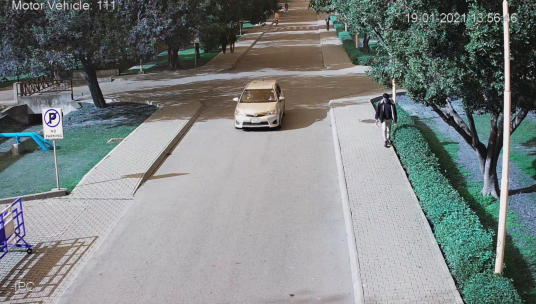

In [ ]:
cv2_imshow(output_viddata[3])

In [ ]:
writer = imageio.get_writer('/content/drive/MyDrive/MLProject/OutputVideos/test_car_6.mp4', fps=10)

for im in output_viddata:
    writer.append_data(im)
writer.close()

### Final Classification of Video 2

In [ ]:
output_viddata = []
cc = 0
for vid in vid_data2:
  if cc < 30:
    winsizex = 30
    winsizey = 45
    stepS = 20
  elif cc < 75:
    winsizex = 50
    winsizey = 55
    stepS = 30
  else:
    winsizex= 65
    winsizey = 80
    stepS = 40

  cc += 1
  working_test = resize(rgb2gray(vid), (152*2, 268*2), anti_aliasing=True)
  tmp0 = resize(vid, (152*2, 268*2), anti_aliasing=True)
  tmp = working_test.copy()
  tmp2 = working_test.copy()
  count = 0
  wins = []
  ones = []
  ones_ann = []
  test_wins = []
  hog_wins = []
  for (winx, winy, winimg) in sliding_window_func(image=working_test,stepSize=stepS,windowSize=(winsizex,winsizey)):
    wins.append([winx,winy])
    test_wins.append(resize(winimg, (64, 64), anti_aliasing=True))
    hog_wins.append(hog_features(resize(winimg, (64, 64), anti_aliasing=True)))
    #test_wins.append(winimg)

  y_pred_cnn = cnn.predict(np.array(test_wins))
  y_pred_ann = ann.predict(np.array(test_wins))
  y_pred_hogann = ann_hog.predict(np.array(hog_wins))

  y_class_cnn = [np.argmax(element) for element in y_pred_cnn]
  y_class_ann = [np.argmax(element) for element in y_pred_ann]
  y_class_hogann = [np.argmax(element) for element in y_pred_hogann]
  #y_class_moto_cnn = 
  result_cnn = np.where(y_class_cnn == np.int64(2))
  result_ann = np.where(y_class_ann == np.int64(2))
  result_hogann = np.where(y_class_hogann == np.int64(2))

  result_cnn2 = np.where(y_pred_cnn.max(axis=1)[result_cnn] > 0.96)
  result_ann2 = np.where(y_pred_ann.max(axis=1)[result_ann] > 0.93)

  intersect = np.intersect1d(result_cnn, result_hogann, result_ann)

  # if intersect:
  #   max_idx = np.argmax(y_pred_cnn.max(axis=1)[intersect])

  #   winx, winy = wins[intersect[max_idx]]
  #   cv2.rectangle(tmp, (winx, winy), (winx+winsizex, winy+winsizey), (150, 40, 0), 2)
  tmp = tmp*255
  tmp0 = tmp0*255
  for idx in intersect:
    winx, winy = wins[idx]
    
    cv2.rectangle(tmp0, (winx, winy), (winx+winsizex, winy+winsizey), (150, 40, 0), 2)

  output_viddata.append(resize(tmp0, (152*2, 268*2), anti_aliasing=True))
  print('Frame ',cc, 'Num of Rects: ',intersect.shape)

Frame  1 Num of Rects:  (2,)
Frame  2 Num of Rects:  (2,)
Frame  3 Num of Rects:  (2,)
Frame  4 Num of Rects:  (2,)
Frame  5 Num of Rects:  (2,)
Frame  6 Num of Rects:  (1,)
Frame  7 Num of Rects:  (1,)
Frame  8 Num of Rects:  (1,)
Frame  9 Num of Rects:  (1,)
Frame  10 Num of Rects:  (1,)
Frame  11 Num of Rects:  (0,)
Frame  12 Num of Rects:  (0,)
Frame  13 Num of Rects:  (0,)
Frame  14 Num of Rects:  (0,)
Frame  15 Num of Rects:  (0,)
Frame  16 Num of Rects:  (0,)
Frame  17 Num of Rects:  (0,)
Frame  18 Num of Rects:  (0,)
Frame  19 Num of Rects:  (0,)
Frame  20 Num of Rects:  (1,)
Frame  21 Num of Rects:  (0,)
Frame  22 Num of Rects:  (0,)
Frame  23 Num of Rects:  (0,)
Frame  24 Num of Rects:  (1,)
Frame  25 Num of Rects:  (1,)
Frame  26 Num of Rects:  (1,)
Frame  27 Num of Rects:  (2,)
Frame  28 Num of Rects:  (1,)
Frame  29 Num of Rects:  (1,)
Frame  30 Num of Rects:  (1,)
Frame  31 Num of Rects:  (0,)
Frame  32 Num of Rects:  (0,)
Frame  33 Num of Rects:  (0,)
Frame  34 Num of Re

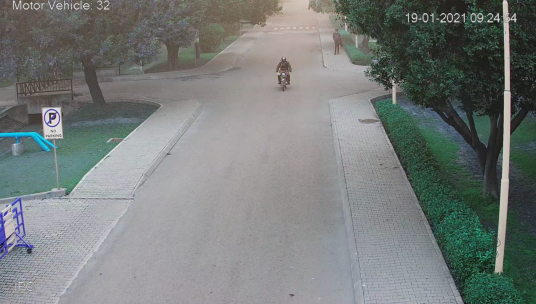

In [ ]:
cv2_imshow(output_viddata[20])

In [ ]:
writer = imageio.get_writer('/content/drive/MyDrive/MLProject/OutputVideos/test_moto_2.mp4', fps=10)

for im in output_viddata:
    writer.append_data(im)
writer.close()